In [3]:
import math
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


def train(model, train_loader, optimizer, scheduler):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, total=len(train_loader)):
        batch = [b.cuda() for b in batch]
        loss = model.loss(*batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    return train_losses


@torch.no_grad()
def eval_loss(model, data_loader):
    model.eval()
    total_loss, total = 0, 0
    for batch in data_loader:
        batch = [b.cuda() for b in batch]
        loss = model.loss(*batch)
        total_loss += loss.item() * batch[0].shape[0]
        total += batch[0].shape[0]
    avg_loss = total_loss / total
    return avg_loss


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        mul = (step + 1) / warmup_steps
        return mul
    else:
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args["epochs"], train_args["lr"]
    warmup_steps = train_args.get("warmup", 0)
    use_cos_decay = train_args.get("use_cos_decay", False)
    optimizer = optim.Adam(model.parameters(), lr)
    total_steps = epochs * len(train_loader)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(
            step, total_steps, warmup_steps, use_cos_decay),
    )

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in tqdm(list(range(epochs))):
        train_loss = train(model, train_loader, optimizer, scheduler)
        train_losses.extend(train_loss)
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(
            f"Epoch {epoch}, Test loss {test_loss:.4f}, Train loss {np.mean(train_loss):.4f}"
        )

    return np.array(train_losses), np.array(test_losses)


class Diffusion:
    def __init__(self, model, data_shape, encode_fn=None, decode_fn=None):
        self.model = model
        self.data_shape = data_shape
        self.encode_fn = encode_fn
        self.decode_fn = decode_fn

    def _get_alpha_sigma(self, t):
        return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

    def _expand(self, t):
        for _ in range(len(self.data_shape)):
            t = t[..., None]
        return t

    def _noise(self, x, eps=None, t=None):
        if t is None:
            t = torch.rand(x.shape[0], dtype=torch.float32, device=x.device)
        if eps is None:
            eps = torch.randn_like(x)
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        x_t = alpha_t * x + sigma_t * eps
        return x_t, eps, t

    def _x_hat(self, x_t, eps_hat, t):
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        return (x_t - sigma_t * eps_hat) / alpha_t

    def loss(self, x, y=None):
        if self.encode_fn is not None:
            x = self.encode_fn(x)
        x_t, eps, t = self._noise(x)
        if y is not None:
            eps_hat = self.model(x_t, y, t)
        else:
            eps_hat = self.model(x_t, t)
        return torch.mean((eps_hat - eps) ** 2)

    @torch.no_grad()
    def sample(self, n, num_steps, clip_denoised=False, model_fn=None, cfg_val=None):
        model_fn = model_fn or self.model

        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1, dtype=np.float32)
        x = torch.randn(n, *self.data_shape, dtype=torch.float32).cuda()
        for i in range(num_steps):
            t_cur = torch.full((n,), ts[i], dtype=torch.float32).cuda()
            t_next = torch.full((n,), ts[i + 1], dtype=torch.float32).cuda()

            alpha_cur, sigma_cur = self._get_alpha_sigma(self._expand(t_cur))
            alpha_next, sigma_next = self._get_alpha_sigma(
                self._expand(t_next))
            ddim_sigma = (sigma_next / sigma_cur) * torch.sqrt(
                1 - alpha_cur**2 / alpha_next**2
            )

            if cfg_val is None:
                eps_hat = model_fn(x, t_cur)
            else:
                eps_hat_cond = model_fn(x, t_cur)
                eps_hat_uncond = model_fn(x, t_cur, dropout_cond=True)
                eps_hat = eps_hat_uncond + cfg_val * \
                    (eps_hat_cond - eps_hat_uncond)

            x_hat = self._x_hat(x, eps_hat, t_cur)
            if clip_denoised:
                x_hat = torch.clamp(x_hat, -1, 1)
            x = (
                alpha_next * x_hat
                + torch.sqrt((sigma_next**2 - ddim_sigma **
                             2).clamp(min=0)) * eps_hat
                + ddim_sigma * torch.randn_like(eps_hat)
            )
        if self.decode_fn is not None:
            x = self.decode_fn(x)
        return x

    def __getattr__(self, name):
        if name in ["train", "eval", "parameters", "state_dict", "load_state_dict"]:
            return getattr(self.model, name)
        return self.__getattribute__(name)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden_layers, timestep_dim=1):
        super().__init__()
        self.timestep_dim = timestep_dim
        prev_dim = input_dim + timestep_dim
        net = []
        dims = [hidden_dim] * n_hidden_layers + [input_dim]
        for i, dim in enumerate(dims):
            net.append(nn.Linear(prev_dim, dim))
            if i < len(dims) - 1:
                net.append(nn.ReLU())
            prev_dim = dim
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        x = torch.cat([x, t[:, None]], dim=1)
        return self.net(x)

In [4]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=4608ad16a896b2f36923f309c15cf2d2e92f30b72d6496716cbed6f6ebf9ce77
  Stored in directory: /tmp/pip-ephem-wheel-cache-1b_pq54e/wheels/23/86/5b/1a90d51ccd0e31aaaf742e323bf5fc5b023a085bb148b117c2
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [5]:
from deepul.hw4_helper import *
import warnings

warnings.filterwarnings("ignore")

# Question 3: Latent-Space Diffusion on CIFAR-10 with DiT [50pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10

Execute the cell below to visualize our datasets.


Files already downloaded and verified
Files already downloaded and verified


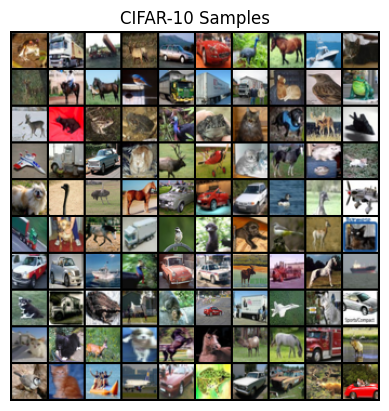

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [6]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.


In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.


In [7]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
    images = 2 * np.transpose(images, (0, 3, 1, 2)) - 1

    real = images[:50]
    z = vae.encode(real)
    recon = vae.decode(z).cpu().numpy()
    autoencoded_images = np.stack((real, recon), axis=1) * 0.5 + 0.5
    autoencoded_images = np.transpose(autoencoded_images, (0, 1, 3, 4, 2))

    zs = []
    for i in range(0, len(images), 100):
        z = vae.encode(images[i: i + 100])
        zs.append(z)
    zs = torch.cat(zs)
    scale_factor = zs.flatten().std().item()

    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


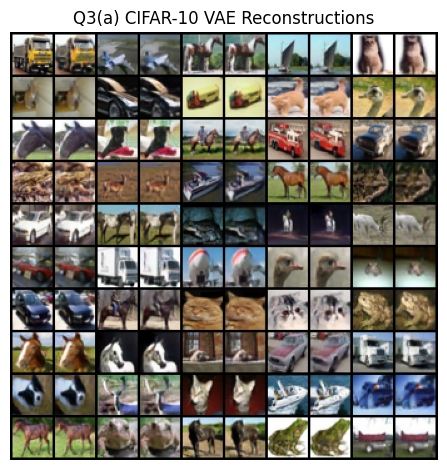

Scale factor: 1.2505


In [8]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]

In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.

```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)

    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)

    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)

    return x

FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x

DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed

    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y

    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)

    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```


**Hyperparameter details**

- (Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
- Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
- Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
- When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder

**Remember to save your model parameters after training, as you will need them for part (c)**


In [9]:
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0,
                                             half, dtype=torch.float32) / half
    ).cuda()
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], axis=-1)
    if dim % 2:
        embedding = torch.cat(
            [embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.wq = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wk = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wv = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wo = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        q, k, v = map(lambda x: x.view(
            *x.shape[:-1], self.num_heads, -1), (q, k, v))
        attn_weights = torch.einsum(
            "bqhd,bkhd->bhqk", q, k) * q.shape[-1] ** -0.5
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_outputs = torch.einsum("bhqk,bkhd->bqhd", attn_weights, v)
        attn_outputs = attn_outputs.reshape(*attn_outputs.shape[:-2], -1)
        return self.wo(attn_outputs)


class MLP(nn.Module):
    def __init__(self, hidden_size, expand=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * expand),
            nn.SiLU(),
            nn.Linear(hidden_size * expand, hidden_size),
        )

    def forward(self, x):
        return self.net(x)


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed


class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.attention = Attention(hidden_size, num_heads)
        self.mlp = MLP(hidden_size)
        self.attention_norm = nn.LayerNorm(
            hidden_size, elementwise_affine=False)
        self.mlp_norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), nn.Linear(hidden_size, 6 * hidden_size)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = (
            self.adaLN_modulation(c).chunk(6, dim=1)
        )
        x = x + gate_msa.unsqueeze(1) * self.attention(
            modulate(self.attention_norm(x), shift_msa, scale_msa)
        )
        x = x + gate_mlp.unsqueeze(1) * self.mlp(
            modulate(self.mlp_norm(x), shift_mlp, scale_mlp)
        )
        return x


class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(
            hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(
            hidden_size, patch_size * patch_size * out_channels, bias=True
        )
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    def __init__(
        self,
        input_shape,
        patch_size,
        hidden_size,
        num_heads,
        num_layers,
        num_classes=10,
        frequency_embedding_size=64,
        cfg_dropout_prob=0.1,
    ):
        super().__init__()
        self.cfg_dropout_prob = cfg_dropout_prob
        self.frequency_embedding_size = frequency_embedding_size
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.patch_size = patch_size

        self.time_embedding = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        # batch_size, num_blocks, hidden_size
        self.label_embedder = nn.Embedding(num_classes + 1,  hidden_size)

        C, H, W = input_shape
        n_patches = (H // patch_size) * (W // patch_size)
        self.patchify = nn.Conv2d(
            C, hidden_size, patch_size, stride=patch_size)
        self.register_buffer(
            "pos_embed",
            torch.FloatTensor(get_2d_sincos_pos_embed(
                hidden_size, H // patch_size)),
        )
        self.blocks = nn.ModuleList(
            [DiTBlock(hidden_size, num_heads) for _ in range(num_layers)]
        )
        self.out_layer = FinalLayer(hidden_size, patch_size, C)

    def unpatchify(self, x):
        C, H, W = self.input_shape
        P = self.patch_size
        x = x.view(x.shape[0], H // P, W // P, P, P, C)
        x.shape[0], H // P, P, W // P, P, C
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(x.shape[0], C, H, W)
        return x

    def forward(self, x, y, t):
        # x: BCHW
        x = self.patchify(x).movedim(1, -1)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x + self.pos_embed

        t = self.time_embedding(timestep_embedding(
            t, self.frequency_embedding_size))
        if self.training:
            drop_ids = torch.rand(
                y.shape[0], device=y.device) < self.cfg_dropout_prob
            y = torch.where(drop_ids, self.num_classes, y)
        y = self.label_embedder(y)
        c = t + y
        for block in self.blocks:
            x = block(x, c)
        x = self.out_layer(x, c)
        return self.unpatchify(x)

In [10]:
def load_q3_data():
    train_data = torchvision.datasets.CIFAR10(
        "./data", transform=torchvision.transforms.ToTensor(), download=True, train=True
    )
    test_data = torchvision.datasets.CIFAR10(
        "./data",
        transform=torchvision.transforms.ToTensor(),
        download=True,
        train=False,
    )
    return train_data, test_data


def show_samples(
    samples: np.ndarray, fname: str = None, nrow: int = 10, title: str = "Samples"
):
    import torch
    from torchvision.utils import make_grid

    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

In [11]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """
    train_data = 2 * np.transpose(train_data, (0, 3, 1, 2)) - 1
    test_data = 2 * np.transpose(test_data, (0, 3, 1, 2)) - 1
    train_data = data.TensorDataset(
        torch.FloatTensor(train_data), torch.LongTensor(train_labels)
    )
    test_data = data.TensorDataset(
        torch.FloatTensor(test_data), torch.LongTensor(test_labels)
    )
    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = data.DataLoader(train_data, batch_size=256)

    scale_factor = 1.3101

    def encode_fn(x):
        z = vae.encode(x)
        z /= scale_factor
        return z

    def decode_fn(z):
        z *= scale_factor
        x = vae.decode(z)
        return x

    model = DiT(
        (4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12
    ).cuda()
    model = Diffusion(model, (4, 8, 8), encode_fn=encode_fn, decode_fn=decode_fn)

    total_params = sum([np.prod(p.shape) for p in model.parameters()])
    print(f"Total parameters: {total_params / 1e6:.3f}M")

    train_losses, test_losses = train_epochs(
        model,
        train_loader,
        test_loader,
        dict(epochs=20, lr=1e-3, warmup=100, use_cos_decay=True),
    )
    torch.save(model.state_dict(), "q3_model.pt")

    labels = torch.arange(10, dtype=torch.long).cuda()
    labels = labels.repeat_interleave(10, dim=0)

    def model_fn(x, t):
        return model.model(x, labels, t)

    samples = model.sample(labels.shape[0], 512, clip_denoised=False, model_fn=model_fn)
    samples = samples.movedim(1, -1).cpu().numpy()
    samples = samples * 0.5 + 0.5
    samples = samples.reshape(10, 10, *samples.shape[1:])
    return train_losses, test_losses, samples


def get_data_dir(hw_number: int):
    return os.path.join("deepul", "homeworks", f"hw{hw_number}", "data")


# TODO: load with own slot compressor autoencoder


def load_pretrain_vae():
    data_dir = get_data_dir(4)
    vae = VAE()
    vae.load_state_dict(torch.load(os.path.join(data_dir, f"vae_cifar10.pth")))
    vae.eval()
    return vae.cuda()

In [13]:
from torchvision.utils import make_grid
import torch

train_data, test_data = load_q3_data()
train_images = train_data.data / 255.0
train_labels = np.array(train_data.targets, dtype=np.int32)
test_images = test_data.data / 255.0
test_labels = np.array(test_data.targets, dtype=np.int32)
vae = load_pretrain_vae()
train_losses, test_losses, samples = q3_b(
    train_images, train_labels, test_images, test_labels, vae
)

print(f"Final Test Loss: {test_losses[-1]:.4f}")
save_training_plot(
    train_losses, test_losses, "Q3(b) Train Plot", "results/q3_b_train_plot.png"
)

samples = samples.reshape(-1, *samples.shape[2:])
show_samples(
    samples * 255.0,
    fname=f"results/q3_b_samples.png",
    title=f"Q3(b) CIFAR-10 generated samples",
)

Files already downloaded and verified
Files already downloaded and verified
Total parameters: 57.534M


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Test loss 0.4202, Train loss 0.5047


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Test loss 0.4066, Train loss 0.4119


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Test loss 0.3995, Train loss 0.4021


  0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: 

Files already downloaded and verified


Files already downloaded and verified
Total parameters: 57.534M


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Test loss 0.4241, Train loss 0.5106


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Test loss 0.4067, Train loss 0.4136


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Test loss 0.3964, Train loss 0.4014


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Test loss 0.3944, Train loss 0.3937


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Test loss 0.3903, Train loss 0.3906


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Test loss 0.3896, Train loss 0.3864


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Test loss 0.3838, Train loss 0.3864


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Test loss 0.3803, Train loss 0.3849


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Test loss 0.3788, Train loss 0.3813


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Test loss 0.3746, Train loss 0.3815


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Test loss 0.3812, Train loss 0.3792


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Test loss 0.3772, Train loss 0.3774


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Test loss 0.3767, Train loss 0.3770


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Test loss 0.3753, Train loss 0.3780


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Test loss 0.3705, Train loss 0.3742


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Test loss 0.3767, Train loss 0.3728


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Test loss 0.3715, Train loss 0.3743


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Test loss 0.3710, Train loss 0.3728


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Test loss 0.3694, Train loss 0.3713


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Test loss 0.3681, Train loss 0.3701


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Test loss 0.3698, Train loss 0.3710


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Test loss 0.3701, Train loss 0.3693


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Test loss 0.3671, Train loss 0.3699


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Test loss 0.3667, Train loss 0.3674


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Test loss 0.3695, Train loss 0.3671


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Test loss 0.3672, Train loss 0.3689


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Test loss 0.3671, Train loss 0.3678


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Test loss 0.3652, Train loss 0.3651


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Test loss 0.3626, Train loss 0.3680


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Test loss 0.3655, Train loss 0.3642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Test loss 0.3654, Train loss 0.3632


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Test loss 0.3629, Train loss 0.3639


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Test loss 0.3620, Train loss 0.3628


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Test loss 0.3654, Train loss 0.3601


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Test loss 0.3622, Train loss 0.3604


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Test loss 0.3611, Train loss 0.3639


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Test loss 0.3607, Train loss 0.3621


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Test loss 0.3590, Train loss 0.3642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Test loss 0.3602, Train loss 0.3629


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Test loss 0.3590, Train loss 0.3582


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Test loss 0.3585, Train loss 0.3594


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Test loss 0.3605, Train loss 0.3619


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Test loss 0.3593, Train loss 0.3563


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Test loss 0.3576, Train loss 0.3583


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Test loss 0.3562, Train loss 0.3591


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Test loss 0.3568, Train loss 0.3572


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Test loss 0.3562, Train loss 0.3568


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Test loss 0.3570, Train loss 0.3593


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Test loss 0.3557, Train loss 0.3577


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Test loss 0.3545, Train loss 0.3564


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Test loss 0.3542, Train loss 0.3546


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Test loss 0.3543, Train loss 0.3560


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Test loss 0.3545, Train loss 0.3557


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Test loss 0.3546, Train loss 0.3539


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Test loss 0.3540, Train loss 0.3553


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Test loss 0.3543, Train loss 0.3551


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Test loss 0.3540, Train loss 0.3541


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Test loss 0.3521, Train loss 0.3555


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Test loss 0.3544, Train loss 0.3531


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Test loss 0.3532, Train loss 0.3535
Final Test Loss: 0.3532


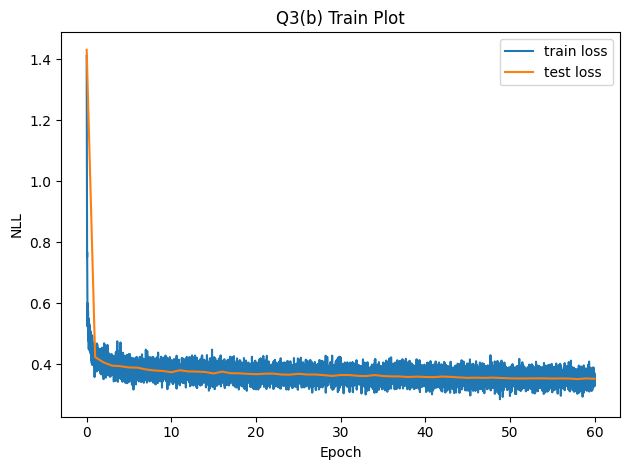

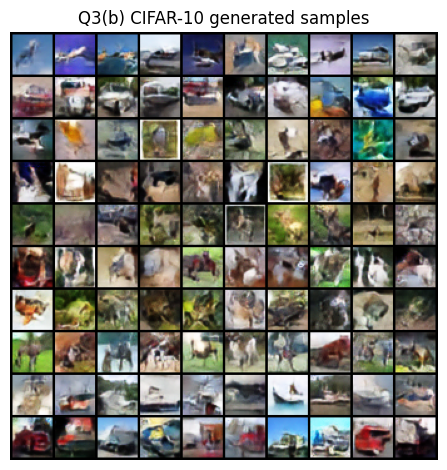

In [ ]:
# q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]

In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)


In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """
    model = DiT(
        (4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12
    ).cuda()
    model = Diffusion(model, (4, 8, 8), encode_fn=vae.encode,
                      decode_fn=vae.decode)
    model.load_state_dict(torch.load("q3_model.pt"))

    cfg_vals = [1.0, 3.0, 5.0, 7.5]
    samples = []
    labels = torch.arange(10, dtype=torch.long).cuda()
    labels = labels.repeat_interleave(10, dim=0)

    # TODO: slots are inserted conditionally

    def model_fn(x, t, dropout_cond=False):
        if dropout_cond:
            new_labels = torch.full_like(labels, 10)
        else:
            new_labels = labels
        return model.model(x, new_labels, t)

    for cfg_val in cfg_vals:
        s = model.sample(
            labels.shape[0],
            512,
            clip_denoised=False,
            model_fn=model_fn,
            cfg_val=cfg_val,
        )
        s = s.movedim(1, -1).cpu().numpy()
        s = s * 0.5 + 0.5
        samples.append(s.reshape(10, 10, *s.shape[1:]))
    samples = np.stack(samples, axis=0)
    return samples

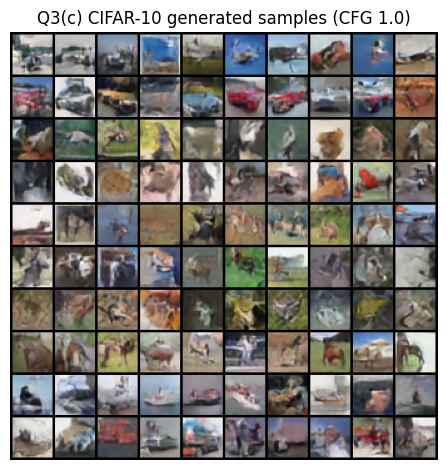

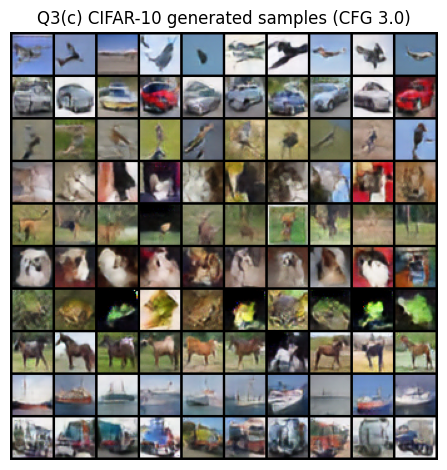

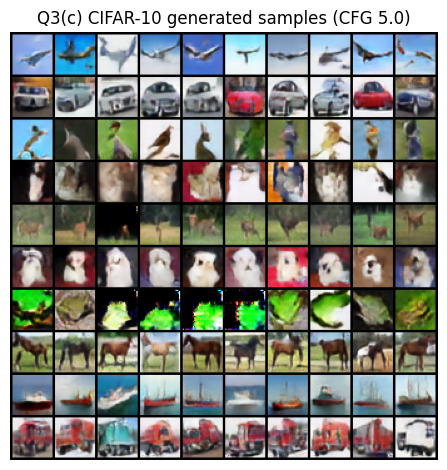

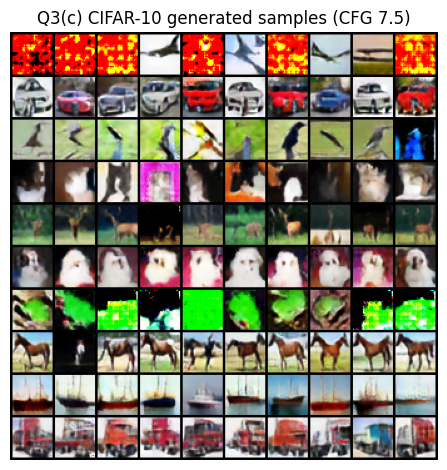

In [ ]:
# q3c_save_results(q3_c)
vae = load_pretrain_vae()
samples = q3_c(vae)
cfg_values = [1.0, 3.0, 5.0, 7.5]
for i in range(4):
    cfg_val = cfg_values[i]
    s = samples[i]
    s = s.reshape(-1, *s.shape[2:])
    show_samples(
        s * 255.0,
        fname=f"results/q3_c_samples_cfg{cfg_val}.png",
        title=f"Q3(c) CIFAR-10 generated samples (CFG {cfg_val})",
    )